## **DBSCAN on Customer Buying Behavior**

In [52]:
#import Necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder,OrdinalEncoder,MinMaxScaler,LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,  silhouette_score
import warnings
warnings.simplefilter(action='ignore', category=Warning)

In [53]:
#load dataset
df = pd.read_excel('/content/Online Retail.xlsx')
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom


# Data Preprocessing

## **1. Data inspection and cleaning**

##### **1.1. Identifying and handling Missing Values **

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [55]:
print("Missing values:\n", df.isnull().sum())

Missing values:
 InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [56]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [57]:
# Identify columns
num_cols = ['Quantity','UnitPrice', 'CustomerID']
cat_cols =['InvoiceNo', 'StockCode', 'Description','Country']
date_cols=['InvoiceDate']

In [58]:
#Handle numerical data
# Impute missing values
df = df.dropna(subset=['CustomerID'])

In [59]:
#Handle Categorical data
# Impute missing values
# Fill missing values in the 'Description' column with "Unknown"
df["Description"] = df["Description"].fillna("Unknown")

In [60]:
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


##### **1.2. Checking Data Types of Columns in the Dataset **

In [61]:
# Check data types for all columns
print("\n" + "="*40)
print("Data Types of All Columns:")
print("="*40)
print(df.dtypes)


Data Types of All Columns:
InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object


##### **1.3. Identifying and handling Outliers **


In [62]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,406829.000000,406829,406829.000000,406829.000000
mean,12.061303,2011-07-10 16:30:57.879207424,3.460471,15287.690570
min,-80995.000000,2010-12-01 08:26:00,0.000000,12346.000000
25%,2.000000,2011-04-06 15:02:00,1.250000,13953.000000
50%,5.000000,2011-07-31 11:48:00,1.950000,15152.000000
75%,12.000000,2011-10-20 13:06:00,3.750000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,248.693370,NaN,69.315162,1713.600303


In [63]:
# Remove negative Quantity values (assuming they represent returns)
df = df[df["Quantity"] > 0]

# Remove rows where UnitPrice is zero
df = df[df["UnitPrice"] > 0]

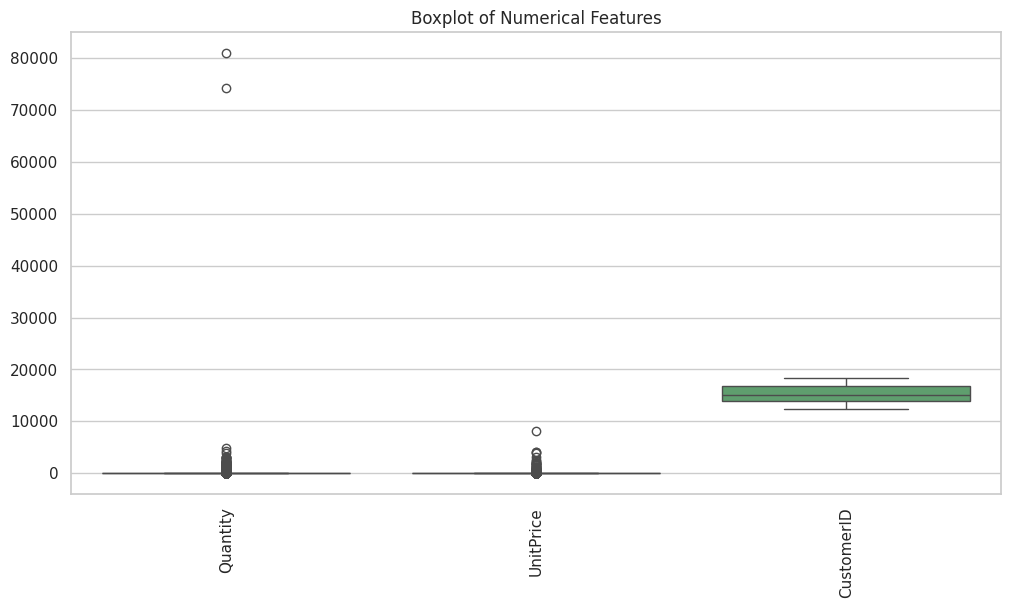

In [64]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df[num_cols])
plt.xticks(rotation=90)  # Rotate column names for better visibility
plt.title("Boxplot of Numerical Features")
plt.show()

In [65]:
df.shape

(397884, 8)

In [66]:
cols = ['Quantity', 'UnitPrice']
for col in cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

In [67]:
df.shape

(338151, 8)

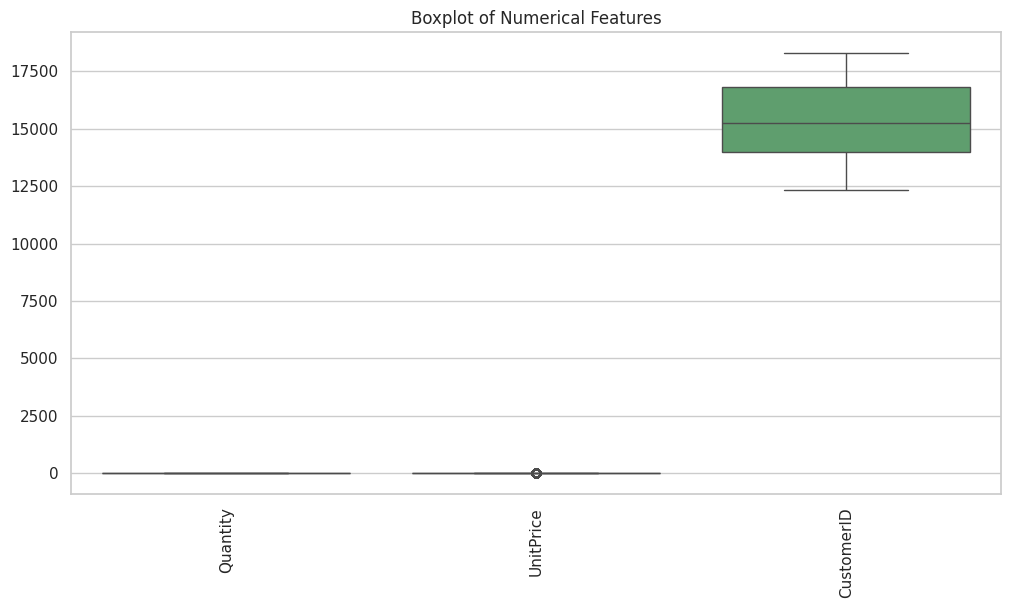

In [68]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df[num_cols])
plt.xticks(rotation=90)  # Rotate column names for better visibility
plt.title("Boxplot of Numerical Features")
plt.show()

##### **1.4. Identifying and handling duplicate Values **

In [69]:
# Check for duplicate rows
duplicate_rows = df.duplicated()
print("Total Duplicate Rows:", duplicate_rows.sum())

Total Duplicate Rows: 4917


In [70]:
df = df.drop_duplicates()

In [71]:
print(df.shape)
print(df.isnull().sum())

(333234, 8)
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


In [72]:
# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Create TotalPrice (Total spending per transaction)
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Aggregate data by CustomerID for clustering
customer_data = df.groupby('CustomerID').agg({
    'TotalPrice': 'sum',      # Total spending
    'Quantity': 'sum',        # Total items purchased
    'InvoiceNo': 'nunique'    # Number of transactions
}).rename(columns={'InvoiceNo': 'NumTransactions'})

# Recency (Days since last purchase)
latest_date = df['InvoiceDate'].max()
recency = df.groupby('CustomerID')['InvoiceDate'].max().apply(lambda x: (latest_date - x).days)
customer_data['Recency'] = recency

# Average Order Value
customer_data['AvgOrderValue'] = customer_data['TotalPrice'] / customer_data['NumTransactions']

# Log Transform to reduce skewness (Adding 1 to avoid log(0))
customer_data[['TotalPrice', 'Quantity', 'AvgOrderValue']] = np.log1p(customer_data[['TotalPrice', 'Quantity', 'AvgOrderValue']])

In [73]:
# Reset index
customer_data.reset_index(inplace=True)
customer_data.shape

(4191, 6)

## **3. Data Normalization**

In [74]:
# Initialize StandardScaler
scaler = StandardScaler()

# Apply StandardScaler to the selected features
customer_data_scaled = scaler.fit_transform(customer_data)

In [75]:
# Display the shape of the preprocessed data
print("Shape of Scaled Customer Data:", customer_data_scaled.shape)

# Show the first few rows of the original customer dataset
print("Sample of Processed Customer Data:")
customer_data.head()

Shape of Scaled Customer Data: (4191, 6)
Sample of Processed Customer Data:


,CustomerID,TotalPrice,Quantity,NumTransactions,Recency,AvgOrderValue
0,12347.0,8.106433,7.546446,7,1,6.162331
1,12348.0,4.513055,4.948760,3,248,3.436135
2,12349.0,6.907905,6.261492,1,18,6.907905
3,12350.0,5.688330,5.283204,1,309,5.688330
4,12352.0,7.031688,6.216606,7,35,5.091065


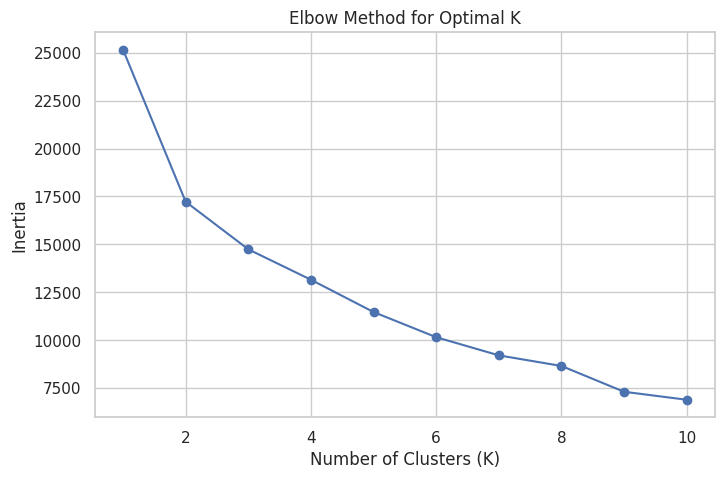

In [76]:
# Elbow method to determine optimal K
inertia = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customer_data_scaled)
    inertia.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

In [77]:
# Try different values of K (excluding K=1, since silhouette score is not defined for 1 cluster)
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(customer_data_scaled)
    score = silhouette_score(customer_data_scaled, labels)
    print(f"K={k}, Silhouette Score={score:.4f}")

K=2, Silhouette Score=0.2925
K=3, Silhouette Score=0.2185
K=4, Silhouette Score=0.2304
K=5, Silhouette Score=0.2319
K=6, Silhouette Score=0.2358
K=7, Silhouette Score=0.2283
K=8, Silhouette Score=0.2259
K=9, Silhouette Score=0.2325
K=10, Silhouette Score=0.2373


### Insights from Clustering Analysis:
 1️⃣ Best K=2 (Silhouette Score = 0.2925)
 → Customers are best separated into low spenders and high spenders,
making segmentation clear and effective.

 2️⃣ K=3 or K=4
 → Further splits customers into low, medium, and high spenders,
but lower silhouette scores suggest less distinct clustering.



Cluster Summary for K=2:
               CustomerID  TotalPrice  Quantity  NumTransactions     Recency  \
Cluster_K2                                                                    
0           15481.331227    5.106708  4.530063         1.612428  147.189047   
1           15133.121728    7.046841  6.521254         6.005236   45.347295   

            AvgOrderValue  
Cluster_K2                 
0                4.772533  
1                5.661741  


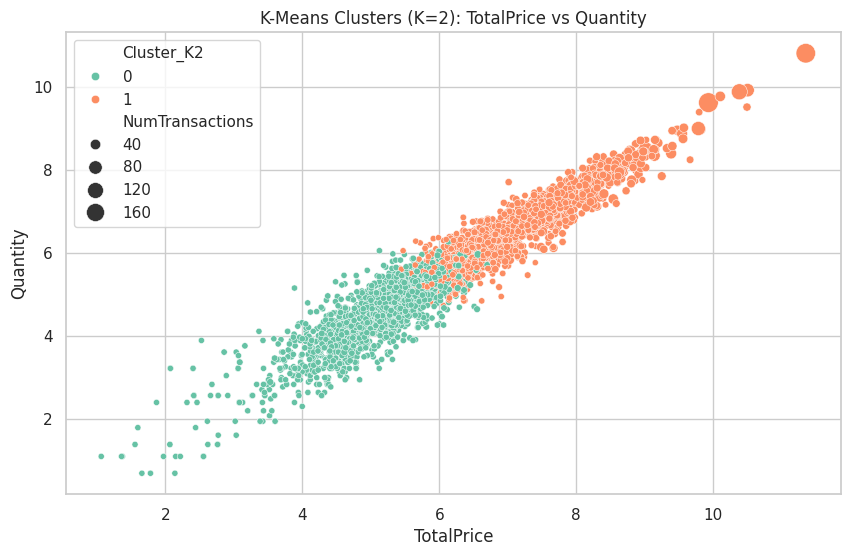


Cluster Summary for K=3:
               CustomerID  TotalPrice  Quantity  NumTransactions     Recency  \
Cluster_K3                                                                    
0           15606.649327    4.733147  4.122540         1.444843  184.690583   
1           15213.285160    6.156129  5.635915         2.515519   72.271096   
2           15101.533531    7.768838  7.230192         9.889546   28.101578   

            AvgOrderValue  
Cluster_K3                 
0                4.482175  
1                5.426749  
2                5.771370  


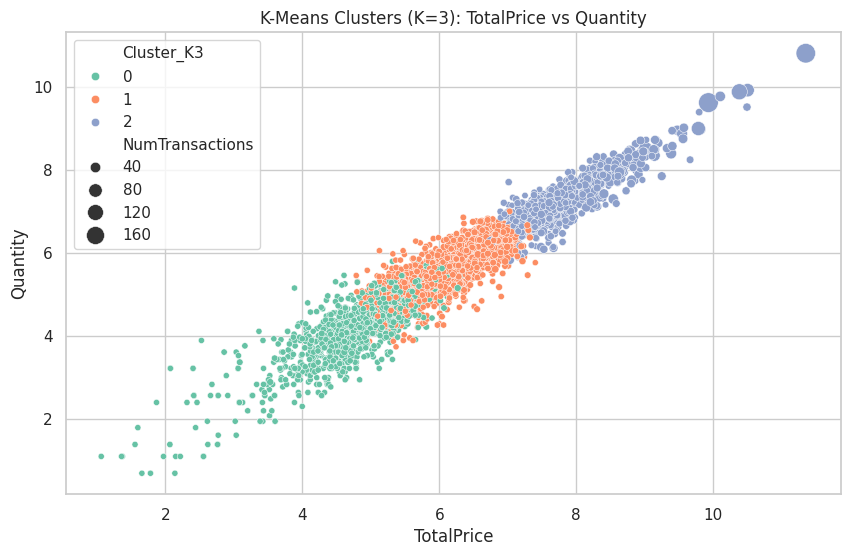


Cluster Summary for K=4:
               CustomerID  TotalPrice  Quantity  NumTransactions     Recency  \
Cluster_K4                                                                    
0           15736.087022    5.443269  4.893030         2.160540   52.508627   
1           14912.889078    6.988054  6.480073         4.251839   53.902094   
2           15470.358871    8.421124  7.818883        21.483871   11.520161   
3           15326.494662    4.930950  4.314975         1.310795  255.459075   

            AvgOrderValue  
Cluster_K4                 
0                4.868252  
1                5.761166  
2                5.524145  
3                4.745435  


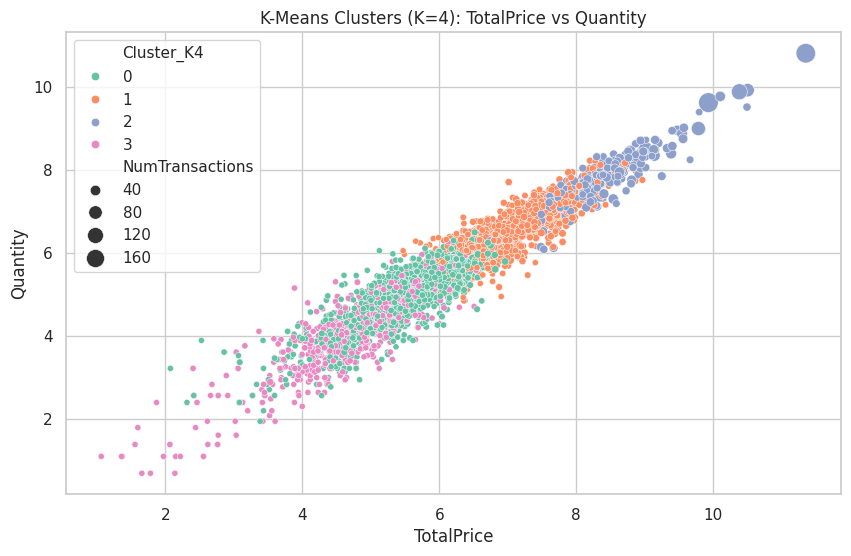

In [78]:
# Function to perform clustering and visualization
def perform_kmeans_clustering(k, customer_data, customer_data_scaled):
    kmeans = KMeans(n_clusters=k, random_state=42)
    customer_data[f'Cluster_K{k}'] = kmeans.fit_predict(customer_data_scaled)

    # Analyze clusters
    cluster_summary = customer_data.groupby(f'Cluster_K{k}').mean()
    print(f"\nCluster Summary for K={k}:\n", cluster_summary)

    # Visualize clusters
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='TotalPrice', y='Quantity', hue=f'Cluster_K{k}', size='NumTransactions',
                    data=customer_data, palette='Set2', sizes=(20, 200))
    plt.title(f'K-Means Clusters (K={k}): TotalPrice vs Quantity')
    plt.show()

# Run clustering for K=2, K=3, and K=4
for k in [2, 3, 4]:
    perform_kmeans_clustering(k, customer_data.copy(), customer_data_scaled)


### Insights:
* K=2 (Two Clusters): Basic segmentation into low and high spenders, but lacks finer details.
* K=3 (Three Clusters - Best Choice):
1. Cluster 0: Low spenders, low frequency, high recency (need
retention).
2. Cluster 1: Medium spenders with moderate transactions & recent activity (potential repeat buyers).
3. Cluster 2: High spenders, frequent transactions, recent purchases (loyal customers).
* K=4 (Four Clusters): Further splits but introduces overlap, making segmentation less clear.
* 📊 Best Choice: K=3 – It provides a balanced segmentation of customer behavior for marketing strategies. 🚀

Cluster Summary:
            CustomerID  TotalPrice  Quantity  NumTransactions     Recency  \
Cluster                                                                    
0        15606.649327    4.733147  4.122540         1.444843  184.690583   
1        15213.285160    6.156129  5.635915         2.515519   72.271096   
2        15101.533531    7.768838  7.230192         9.889546   28.101578   

         AvgOrderValue  
Cluster                 
0             4.482175  
1             5.426749  
2             5.771370  


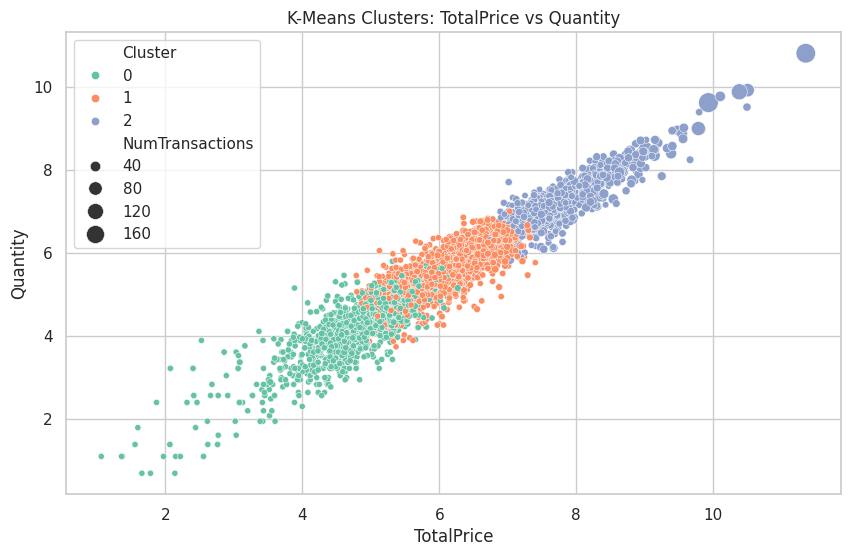

In [79]:
# Apply K-Means with optimal K=3
kmeans = KMeans(n_clusters=3, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(customer_data_scaled)

# Analyze clusters
cluster_summary = customer_data.groupby('Cluster').mean()
print("Cluster Summary:\n", cluster_summary)

# Visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TotalPrice', y='Quantity', hue='Cluster', size='NumTransactions',
                data=customer_data, palette='Set2', sizes=(20, 200))
plt.title('K-Means Clusters: TotalPrice vs Quantity')
plt.show()

##Insights
Clusters categorize customers into low, medium, and high spenders based on TotalPrice and Quantity.
The size of the points (NumTransactions) represents transaction frequency, highlighting how often customers make purchases.

In the graph:

* Smaller points indicate infrequent buyers, likely occasional shoppers.
* Larger points represent frequent buyers, indicating high * engagement and loyalty.
* Clusters are visually distinct, showing spending patterns and purchasing behavior effectively.
-> This visualization helps identify customer segments for targeted marketing and strategic decision-making.

Number of clusters (excluding noise): 11
Noise points (Cluster -1): 781


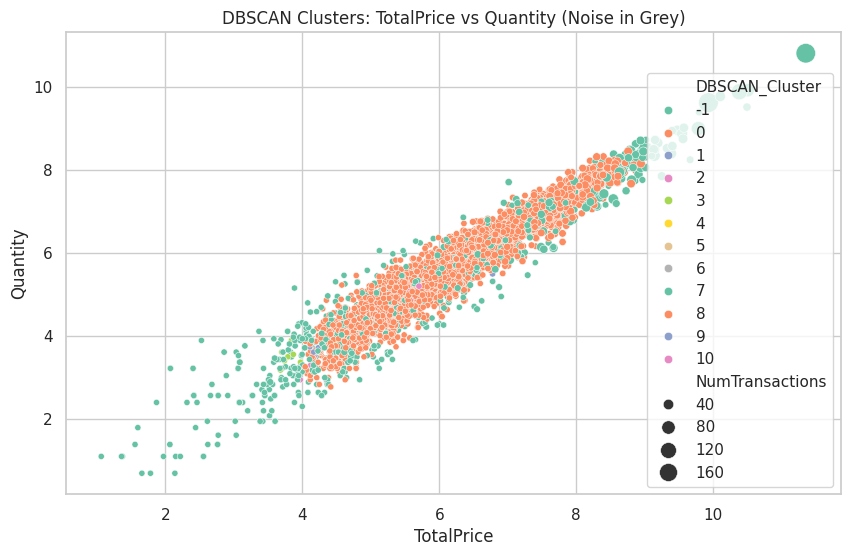

In [80]:
# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)  # eps and min_samples may need tuning
customer_data['DBSCAN_Cluster'] = dbscan.fit_predict(customer_data_scaled)

# Analyze DBSCAN results
print("Number of clusters (excluding noise):", len(set(customer_data['DBSCAN_Cluster'])) - 1)
print("Noise points (Cluster -1):", (customer_data['DBSCAN_Cluster'] == -1).sum())

# Visualize DBSCAN clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TotalPrice', y='Quantity', hue='DBSCAN_Cluster', size='NumTransactions',
                data=customer_data, palette='Set2', sizes=(20, 200))
plt.title('DBSCAN Clusters: TotalPrice vs Quantity (Noise in Grey)')
plt.show()

# Insight
* DBSCAN identified 11 customer clusters based on TotalPrice and Quantity, highlighting different spending patterns.
* DBSCAN detects noise points (-1), capturing outliers that K-Means might misclassify.
* Clusters are density-based, leading to fewer but more meaningful groups compared to K-Means.

K-Means Silhouette Score: 0.219

K-Means Cluster Counts:
 Cluster
1    2062
0    1115
2    1014
Name: count, dtype: int64

DBSCAN Cluster Counts:
 DBSCAN_Cluster
 0     3354
-1      781
 4        8
 1        7
 6        7
 3        7
 2        5
 5        5
 7        5
 8        5
 9        4
 10       3
Name: count, dtype: int64


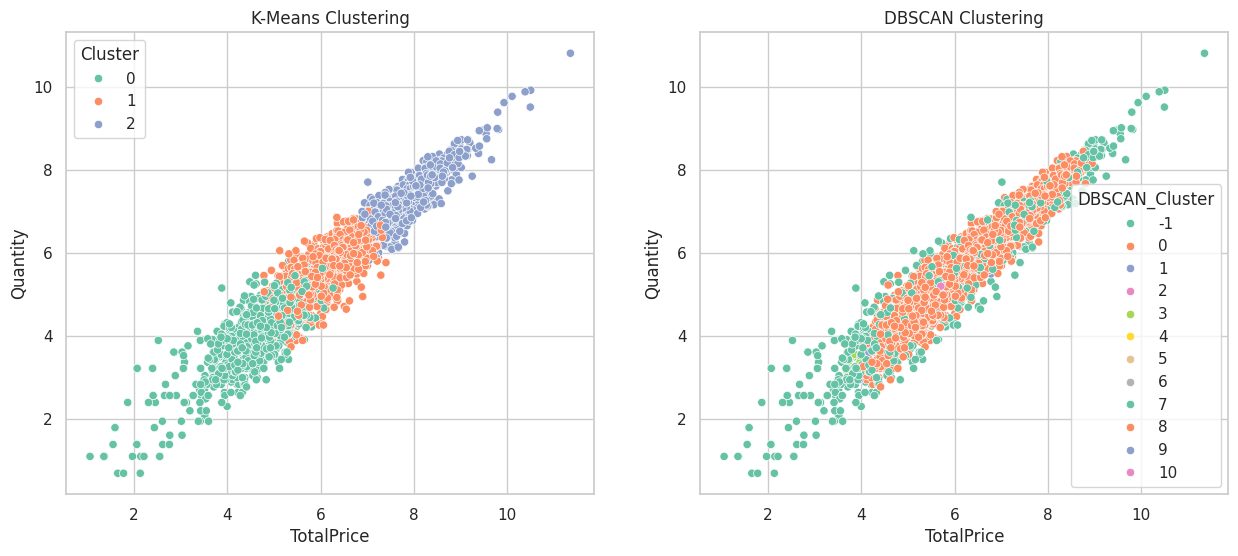

In [81]:
# Silhouette scores (for K-Means only, as DBSCAN may have noise)
kmeans_silhouette = silhouette_score(customer_data_scaled, customer_data['Cluster'])
print(f"K-Means Silhouette Score: {kmeans_silhouette:.3f}")

# Count of points per cluster
print("\nK-Means Cluster Counts:\n", customer_data['Cluster'].value_counts())
print("\nDBSCAN Cluster Counts:\n", customer_data['DBSCAN_Cluster'].value_counts())

# Visualize side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sns.scatterplot(x='TotalPrice', y='Quantity', hue='Cluster', data=customer_data,
                palette='Set2', ax=ax1)
ax1.set_title('K-Means Clustering')
sns.scatterplot(x='TotalPrice', y='Quantity', hue='DBSCAN_Cluster', data=customer_data,
                palette='Set2', ax=ax2)
ax2.set_title('DBSCAN Clustering')
plt.show()

# Insights & Analysis

## Preprocessing Observations:
- **Log Transformation:** Likely applied to `TotalPrice` and `Quantity` to manage skewness caused by high-value transactions.
- **Scaling:** Standardization ensures balanced weighting for clustering.

## Exploratory Data Insights:
- **Customer Spending Patterns:** Significant variation exists in spending and transaction frequency.
- **Correlation:** `TotalPrice` and `Quantity` show a strong positive correlation, meaning higher spending aligns with bulk purchases.

## K-Means Clustering Analysis:
- **Cluster Distribution:**  
  - Cluster 1: 2062 points (largest group)  
  - Cluster 0: 1115 points  
  - Cluster 2: 1014 points  
- **Silhouette Score:** **0.219**, indicating **weakly defined clusters** with potential overlap.
- **Characteristics:**
  - Forms **three clusters** representing different spending segments.
  - **Drawbacks:** Assumes **spherical** clusters and is sensitive to **outliers**.

## DBSCAN Clustering Analysis:
- **Cluster Distribution:**  
  - Major cluster (Cluster 0) contains **3354 points**.  
  - **781 points classified as noise** (-1), meaning outliers or sparse points.  
  - Remaining **small clusters (3-10 points each)** suggest minor spending groups.  
- **Key Observations:**
  - **Better at detecting outliers** compared to K-Means.
  - **Density-based approach** results in a higher number of small, distinct clusters.
  - **No forced assignments** (unlike K-Means), allowing for more natural grouping.

## Comparison:

| Feature          | K-Means | DBSCAN |
|-----------------|---------|--------|
| **Cluster Count** | 3 main clusters | 1 major cluster, multiple small ones |
| **Outlier Detection** | No (includes all points) | Yes (781 noise points) |
| **Cluster Shape** | Spherical | Irregular, density-based |
| **Performance** | Defined segmentation but weak cohesion (Silhouette Score = 0.219) | Adaptive but small clusters require tuning |

## Recommendations:
- **K-Means is suitable** for structured customer segmentation (e.g., marketing strategies).
- **DBSCAN is better** for identifying **outliers** (e.g., unusual high-spending customers).
- **Further tuning needed** for DBSCAN’s `eps` and `min_samples` to balance noise detection and cluster formation.
